In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy.crs as ccrs
import math
from geographiclib.geodesic import Geodesic
import numpy as np
import scipy.stats as stats
import arviz as az

In [22]:
folder = "NM/"

In [4]:
df = pd.read_csv(folder+"points.csv").drop("Unnamed: 0",axis=1)
df

,datetime,point,precise,lat,lng,ghpe
0,2024:04:27 13:37:25,P3,on,45.828367,15.220606,4.728331
1,2024:04:27 13:34:38,P2,on,45.828425,15.220233,3.535534
2,2024:04:27 13:35:11,P2,on,45.828431,15.220286,4.765481
3,2024:04:27 13:38:05,P3,off,45.808922,15.227494,3335.101205
4,2024:04:27 13:35:07,P2,on,45.828433,15.220283,4.757386
...,...,...,...,...,...,...
425,2024:04:27 13:36:45,P3,on,45.828403,15.220358,4.592672
426,2024:04:27 13:34:55,P2,on,45.828431,15.220247,4.592672
427,2024:04:27 13:33:09,P1,on,45.828469,15.220489,4.751959
428,2024:04:27 13:34:43,P2,on,45.828431,15.220244,4.169383


In [5]:
df = df[["point","precise","lat","lng"]]
df = df[(df["precise"]=="on")|(df["point"]=="SPOT")]
df

,point,precise,lat,lng
0,P3,on,45.828367,15.220606
1,P2,on,45.828425,15.220233
2,P2,on,45.828431,15.220286
4,P2,on,45.828433,15.220283
5,P1,on,45.828472,15.220489
...,...,...,...,...
425,P3,on,45.828403,15.220358
426,P2,on,45.828431,15.220247
427,P1,on,45.828469,15.220489
428,P2,on,45.828431,15.220244


In [6]:
# compute P1, P2, P3 (average), get E
# latitude (N) and longitude (E)
df_mean = df.drop("precise",axis=1).groupby("point").mean()
d = dict(df_mean)
for k in d.keys():
    d[k] = dict(d[k])
# P1 = (d["lng"]["P1"],d["lat"]["P1"])
# P2 = (d["lng"]["P2"],d["lat"]["P2"])
# P3 = (d["lng"]["P3"],d["lat"]["P3"])
# E = (d["lng"]["SPOT"],d["lat"]["SPOT"])
P1 = (d["lat"]["P1"],d["lng"]["P1"])
P2 = (d["lat"]["P2"],d["lng"]["P2"])
P3 = (d["lat"]["P3"],d["lng"]["P3"])
E = (d["lat"]["SPOT"],d["lng"]["SPOT"])
P1,P2,P3,E

((45.82847186111111, 15.22048538888889),
 (45.82843192982457, 15.220255146198829),
 (45.82838566784871, 15.220487234042553),
 (45.82836944444445, 15.220408333333332))

In [7]:
def lat_lng2dist_ang(initial_coords, coords):
    # initial_coords = [lat1, lng1] (evidence)
    # coords = [lat2, lng2] (proposed)
    # returns meters, radians
    results = Geodesic.WGS84.Inverse(initial_coords[0], initial_coords[1], coords[0], coords[1])
    distance = results['s12']
    angle = math.radians(results['azi1'])
    angle = angle if angle > 0 else angle + 2 * math.pi
    return distance, angle


E_dist_angle_wrt_P1 = lat_lng2dist_ang(P1, E)
E_dist_angle_wrt_P2 = lat_lng2dist_ang(P2, E)
E_dist_angle_wrt_P3 = lat_lng2dist_ang(P3, E)

print("E_dist_angle_wrt_P1", E_dist_angle_wrt_P1)
print("E_dist_angle_wrt_P2", E_dist_angle_wrt_P2)
print("E_dist_angle_wrt_P3", E_dist_angle_wrt_P3)


E_dist_angle_wrt_P1 (12.86199270467897, 3.625805158152281)
E_dist_angle_wrt_P2 (13.781015245474594, 2.0989763923620766)
E_dist_angle_wrt_P3 (6.390458846451682, 4.426333776256516)


In [10]:
def prepare_points(ref_point, excel_path = None, df=None, longitudes_col="lat", latitudes_col="lng"):
    # either excel_path or df is needed
    # ref_point = [lat, lng]
    if df is None:
        df = pd.read_excel(excel_path, header=1).loc[:, [longitudes_col, latitudes_col]]
        df.columns = ["lng", "lat"]
        
    df["dist"] = df.apply(lambda x: lat_lng2dist_ang(ref_point, [x["lat"], x["lng"]])[0], axis=1)
    df["angle"] = df.apply(lambda x: lat_lng2dist_ang(ref_point, [x["lat"], x["lng"]])[1], axis=1)
    return df

df_p1 = prepare_points(P1, df = pd.DataFrame(df[df["point"] == "P1"]).drop("point", axis=1))
df_p2 = prepare_points(P2, df = pd.DataFrame(df[df["point"] == "P2"]).drop("point", axis=1))
df_p3 = prepare_points(P3, df = pd.DataFrame(df[df["point"] == "P3"]).drop("point", axis=1))


display(df_p1)
display(df_p2)
display(df_p3)

df_p1.to_csv(folder+"p1.csv", index=False)
df_p2.to_csv(folder+"p2.csv", index=False)
df_p3.to_csv(folder+"p3.csv", index=False)

,precise,lat,lng,dist,angle
5,on,45.828472,15.220489,0.274904,1.424270
8,on,45.828472,15.220489,0.274904,1.424270
11,on,45.828475,15.220489,0.442356,0.662125
12,on,45.828464,15.220486,0.887872,3.078345
18,on,45.828469,15.220489,0.382245,2.349996
...,...,...,...,...,...
413,on,45.828472,15.220475,0.808238,4.762069
415,on,45.828464,15.220489,0.926892,2.843802
416,on,45.828472,15.220492,0.489446,1.488700
427,on,45.828469,15.220489,0.382245,2.349996


,precise,lat,lng,dist,angle
1,on,45.828425,15.220233,1.861716,4.285849
2,on,45.828431,15.220286,2.410891,1.634196
4,on,45.828433,15.220283,2.195756,1.499691
6,on,45.828425,15.220222,2.671706,4.419945
7,on,45.828431,15.220242,1.058471,4.567574
...,...,...,...,...,...
407,on,45.828431,15.220281,1.980267,1.648008
408,on,45.828431,15.220247,0.634376,4.469216
418,on,45.828431,15.220242,1.058471,4.567574
426,on,45.828431,15.220247,0.634376,4.469216


,precise,lat,lng,dist,angle
0,on,45.828367,15.220606,9.433322,1.796590
16,on,45.828367,15.220606,9.433322,1.796590
17,on,45.828425,15.220289,16.019931,4.988787
21,on,45.828408,15.220336,12.009810,4.923723
22,on,45.828367,15.220606,9.433322,1.796590
...,...,...,...,...,...
397,on,45.828367,15.220606,9.433322,1.796590
420,on,45.828425,15.220286,16.227686,4.985157
423,on,45.828367,15.220606,9.433322,1.796590
424,on,45.828431,15.220281,16.816560,5.013607


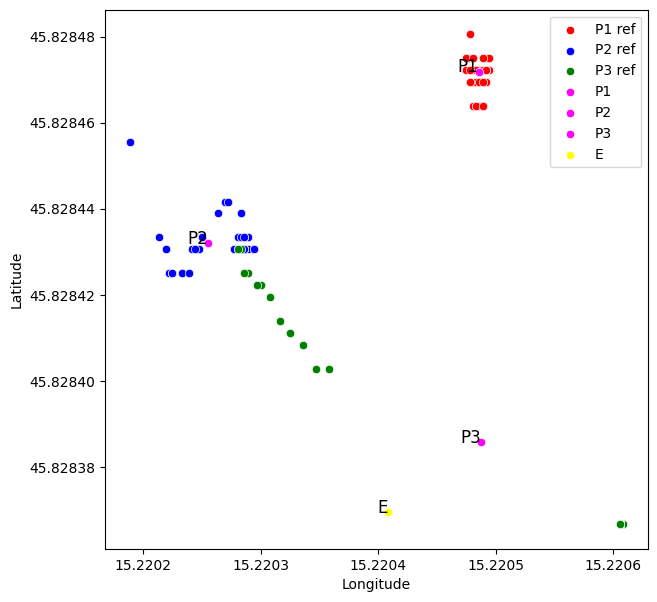

In [11]:
# TODO: modify this so it is using a projection (e.g. Mercator) for longitude and latitude to the x and y axis.
# Currently, the points are close enough to each other so it's not a big deal, but it's not correct.
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=df_p1, x="lng", y="lat", ax=ax, label="P1 ref", color="red")
sns.scatterplot(data=df_p2, x="lng", y="lat", ax=ax, label="P2 ref", color="blue")
sns.scatterplot(data=df_p3, x="lng", y="lat", ax=ax, label="P3 ref", color="green")
sns.scatterplot(x=[P1[1]], y=[P1[0]], ax=ax, label="P1", color="magenta")
sns.scatterplot(x=[P2[1]], y=[P2[0]], ax=ax, label="P2", color="magenta")
sns.scatterplot(x=[P3[1]], y=[P3[0]], ax=ax, label="P3", color="magenta")
sns.scatterplot(x=[E[1]], y=[E[0]], ax=ax, label="E", color="yellow")
ax.text(P1[1], P1[0], "P1", fontsize=12, ha='right')
ax.text(P2[1], P2[0], "P2", fontsize=12, ha='right')
ax.text(P3[1], P3[0], "P3", fontsize=12, ha='right')
ax.text(E[1], E[0], "E", fontsize=12, ha='right')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)


From here we can immediately tell, that E is more probable given the points from P1 and P1 itself. The results should reflect/quantify this.

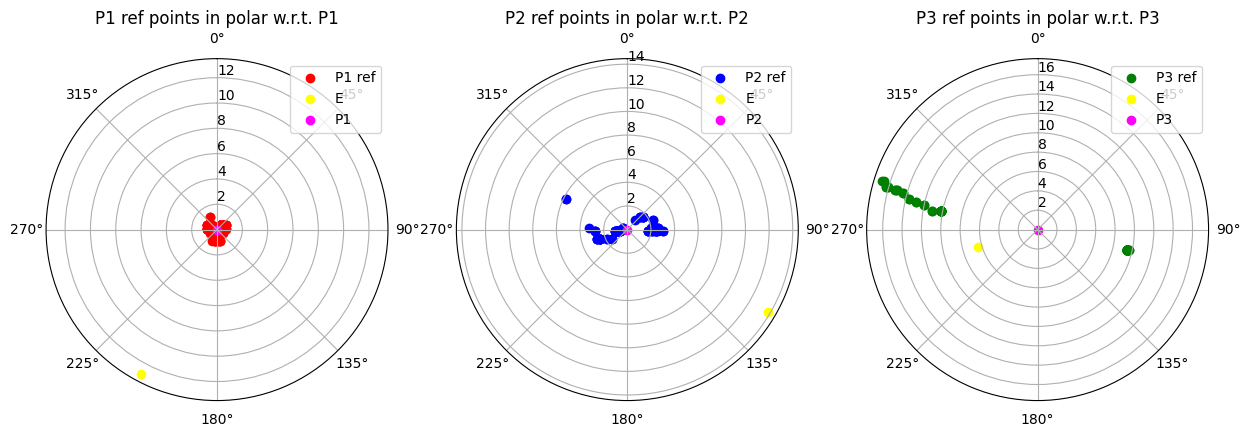

In [12]:
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15,7))
for ax1 in ax.flatten():
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_rlabel_position(0)

ax[0].scatter(df_p1["angle"], df_p1["dist"], label="P1 ref", color="red")
ax[0].set_title("P1 ref points in polar w.r.t. P1")
ax[0].scatter(E_dist_angle_wrt_P1[1], E_dist_angle_wrt_P1[0], label="E", color="yellow")
ax[0].scatter(0, 0, label="P1", color="magenta")
ax[0].legend()

ax[1].scatter(df_p2["angle"], df_p2["dist"], label="P2 ref", color="blue")
ax[1].set_title("P2 ref points in polar w.r.t. P2")
ax[1].scatter(E_dist_angle_wrt_P2[1], E_dist_angle_wrt_P2[0], label="E", color="yellow")
ax[1].scatter(0, 0, label="P2", color="magenta")
ax[1].legend()

ax[2].scatter(df_p3["angle"], df_p3["dist"], label="P3 ref", color="green")
ax[2].set_title("P3 ref points in polar w.r.t. P3")
ax[2].scatter(E_dist_angle_wrt_P3[1], E_dist_angle_wrt_P3[0], label="E", color="yellow")
ax[2].scatter(0, 0, label="P3", color="magenta")
ax[2].legend()
plt.show()


The polar chart seems to make sense. So P1 and P2 are computed w.r.t. the evidence point. Azimuth is measured clockwise, 0 deg being straight up. Therefore P2 is at approx. 45 degrees of azimuth w.r.t E and P1 is a bit below 360 deg azimuth.


### Bayesian approach

In [13]:
import subprocess

subprocess.call (["/usr/bin/Rscript", "bayesian.r", folder, "p1"])
subprocess.call (["/usr/bin/Rscript", "bayesian.r", folder, "p2"])
subprocess.call (["/usr/bin/Rscript", "bayesian.r", folder, "p3"])

This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/lema/.cmdstan/cmdstan-2.34.1
- CmdStan version: 2.34.1
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
This is posterior version 1.5.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

The C++ toolchain required for CmdStan is setup properly!
trying URL 'https://api.github.com/repos/stan-dev/cmdstan/releases/latest'
Content type 'application/json; charset=utf-8' length 17560 bytes (17 KB)
downloaded 17 KB

* Latest CmdStan release is v2.34.1
* Installing CmdStan v2.34.1 in /home/lema

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrain

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iter

Warning message:
Dropping 'draws_df' class as required metadata was removed. 
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/lema/.cmdstan/cmdstan-2.34.1
- CmdStan version: 2.34.1
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
This is posterior version 1.5.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

The C++ toolchain required for CmdStan is setup properly!
trying URL 'https://api.github.com/repos/stan-dev/cmdstan/releases/latest'
Content type 'application/json; charset=utf-8' length 17560 bytes (17 KB)
downloaded 17 KB



Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 1 Iteration: 1200 / 2000 [ 60%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrain

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 2 Iteration: 1300 / 2000 [ 65%]  (Sampling) 
Chain 2 Iteration: 1400 / 2000 [ 70%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 

Warning message:
Dropping 'draws_df' class as required metadata was removed. 
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- CmdStan path: /home/lema/.cmdstan/cmdstan-2.34.1
- CmdStan version: 2.34.1
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting
This is posterior version 1.5.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

The C++ toolchain required for CmdStan is setup properly!
trying URL 'https://api.github.com/repos/stan-dev/cmdstan/releases/latest'
Content type 'application/json; charset=utf-8' length 17560 bytes (17 KB)
downloaded 17 KB



Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 1 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 1 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 1 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 1 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 1 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 1 Iteration:  900 / 2000 [ 45%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 1 Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
Chain 1 
Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Chain 2 Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/tmp/RtmpnTXTXz/model-33a31db657ca.stan', line 14, column 4 to column 32)
Chain 2 If this warning occurs sporadically, such as for highly

Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 2 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 2 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 2 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration:  600 / 2000 [ 30%]  (Warmup) 
Chain 2 Iteration:  700 / 2000 [ 35%]  (Warmup) 
Chain 2 Iteration:  800 / 2000 [ 40%]  (Warmup) 
Chain 2 Iteration:  900 / 2000 [ 45%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1100 / 2000 [ 55%]  (Sampling) 
Chain 2 Iteration: 1200 / 2000 [ 60%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  100 / 2000 [  5%]  (Warmup) 
Chain 3 Iteration:  200 / 2000 [ 10%]  (Warmup) 
Chain 3 Iteration:  300 / 2000 [ 15%]  (Warmup) 
Chain 3 Iteration:  400 / 2000 [ 20%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iterat

Warning message:
Dropping 'draws_df' class as required metadata was removed. 


0

In [21]:
# folder = "original/"
# TODO ploti posebej

In [19]:
# Read the MCMC draws (each row, is a parametrization of a bivariate normal distribution)
p1_draws_df = pd.read_csv(folder+'p1_draws.csv')
p2_draws_df = pd.read_csv(folder+'p2_draws.csv')

# Reshape the data to mean vector and covariance matrix for each draw
p1_mean = p1_draws_df[['mu_dist', 'mu_angle']].values
p1_covariance = p1_draws_df[['sigma11', 'sigma12', 'sigma21', 'sigma22']].values.reshape(-1, 2, 2)
p2_mean = p2_draws_df[['mu_dist', 'mu_angle']].values
p2_covariance = p2_draws_df[['sigma11', 'sigma12', 'sigma21', 'sigma22']].values.reshape(-1, 2, 2)

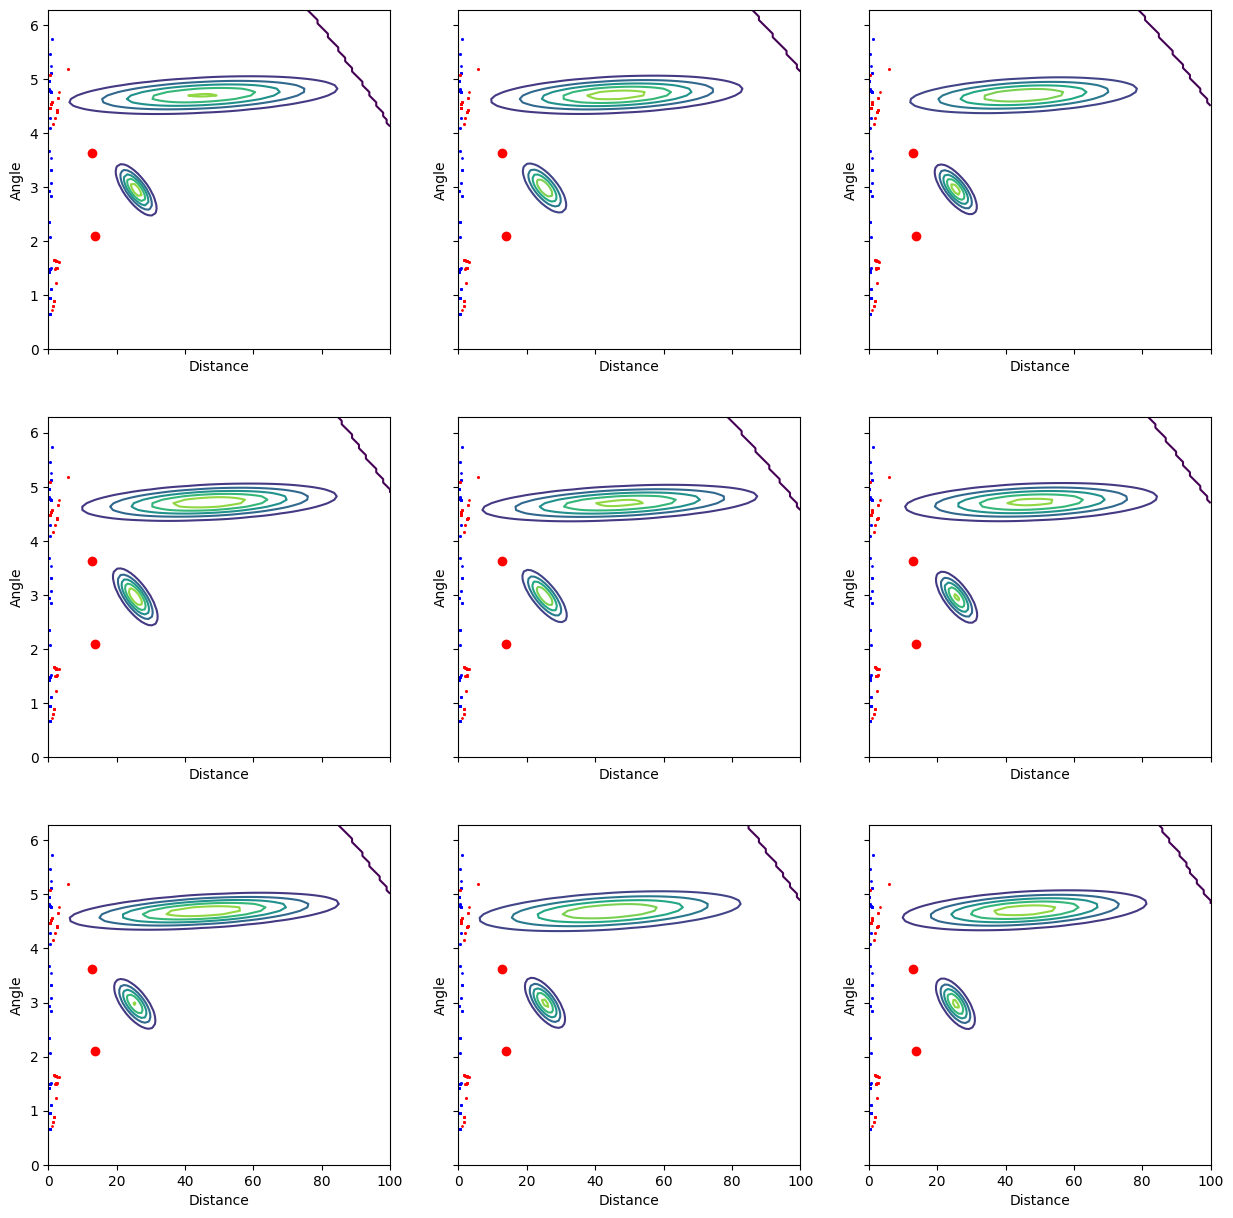

In [24]:
# Create a grid of points for plotting the contours
distance = np.linspace(0, 100, 100)
angle = np.linspace(0, 2* math.pi, 100)
X, Y = np.meshgrid(distance, angle)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# Sample points from the multivariate normal parametrized by the draws
zs = []
# Plot 9 random fitted bivariate normal distributions
fig, ax = plt.subplots(3,3, figsize=(15, 15), sharex=True, sharey=True)
for ax1 in ax.flatten():
    i = np.random.choice(range(len(p1_mean)))
    Z = stats.multivariate_normal.pdf(pos, mean=p1_mean[i], cov=p1_covariance[i])
    ax1.contour(X, Y, Z, 5)
    Z = stats.multivariate_normal.pdf(pos, mean=p2_mean[i], cov=p2_covariance[i])
    ax1.contour(X, Y, Z, 5)
    ax1.set_xlabel('Distance')
    ax1.set_ylabel('Angle')

    # Plot the points
    ax1.scatter(df_p1['dist'], df_p1['angle'], c='b', label='P1 ref', s=1)
    ax1.scatter(df_p2['dist'], df_p2['angle'], c='r', label='P2 ref', s=1)
    ax1.scatter(E_dist_angle_wrt_P1[0], E_dist_angle_wrt_P1[1], c='r', label='P1')
    ax1.scatter(E_dist_angle_wrt_P2[0], E_dist_angle_wrt_P2[1], c='r', label='P2')


Probability of E given P1: 0.0001878340426002999 +/- 0.00010604150614639447
Probability of E given P2: 1.3040718018112846e-38 +/- 5.039243167544597e-37
LR: 22,599,404,903,067,801,143,136,019,239,018,537,317,049,974,749,396,992 +/- 942,886,535,542,009,521,689,224,162,757,957,326,789,128,693,825,404,928
min LR: 8,087,591,412,915,835,757,286,245,007,360, max LR: 56,463,644,765,936,586,810,975,322,681,571,064,975,062,059,631,981,363,200
95% HDI of LR: [8,087,591,412,915,835,757,286,245,007,360, 1,153,982,447,913,676,259,280,655,298,933,490,505,702,189,301,760]


MemoryError: Unable to allocate 12.2 TiB for an array with shape (1671266812510,) and data type float64

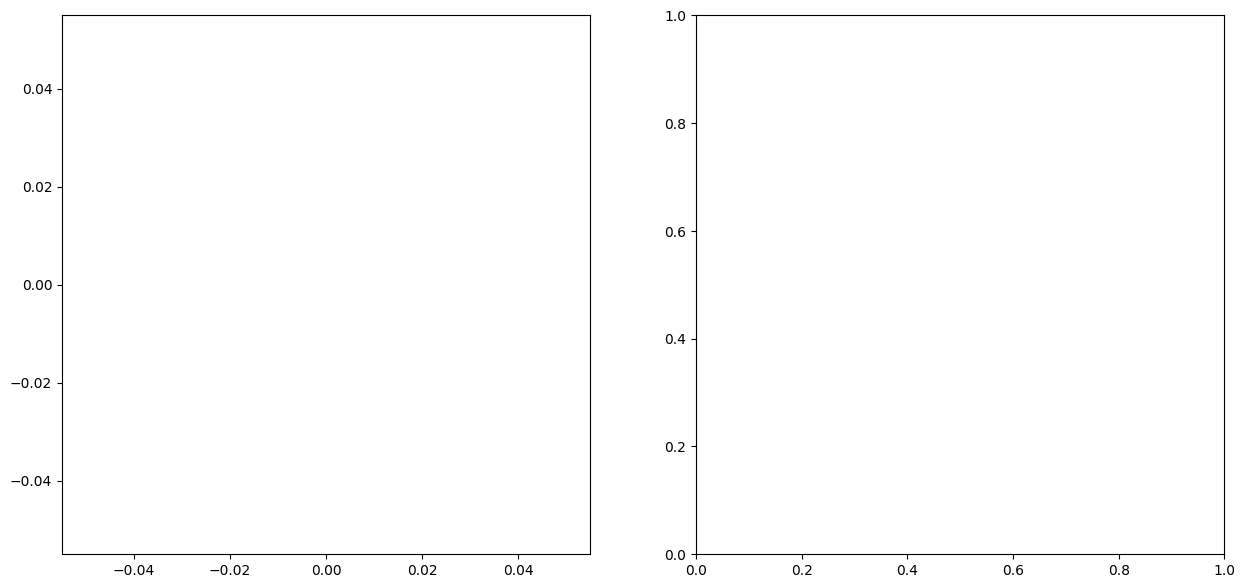

In [25]:
# Evaluate each sampled bivariate normal distribution at the point E (with respect to P1 and P2)
# This results in a bunch of probabilities P(E|P1) and P(E|P2)
e_given_p1_probs = []
e_given_p2_probs = []

for i in range(len(p1_mean)):
    e_given_p1_probs.append(stats.multivariate_normal.pdf(E_dist_angle_wrt_P1, mean=p1_mean[i], cov=p1_covariance[i]))
    e_given_p2_probs.append(stats.multivariate_normal.pdf(E_dist_angle_wrt_P2, mean=p2_mean[i], cov=p2_covariance[i]))

e_given_p1_probs = np.array(e_given_p1_probs)
e_given_p2_probs = np.array(e_given_p2_probs)

print(f"Probability of E given P1: {e_given_p1_probs.mean()} +/- {e_given_p1_probs.std()}")
print(f"Probability of E given P2: {e_given_p2_probs.mean()} +/- {e_given_p2_probs.std()}")

# Compute likelihood ratios from the probabilities
lrs = (e_given_p1_probs / e_given_p2_probs)
hdi_min, hdi_max = az.hdi(lrs, hdi_prob=0.95)
# Show summary statistics
# min and max LR
print(f"LR: {round(lrs.mean()):,} +/- {round(lrs.std()):,}")
print(f"min LR: {round(lrs.min()):,}, max LR: {round(lrs.max()):,}")
print(f"95% HDI of LR: [{round(hdi_min):,}, {round(hdi_max):,}]")



# Plot a histogram of likelihood ratios
fig, ax = plt.subplots(1, 2, figsize=(15,7))
# two histograms ,one with log x one without
sns.histplot(lrs, kde=True, ax=ax[0])
sns.histplot(lrs, kde=True, ax=ax[1], log_scale=(True, False))
ax[0].set_xlabel("Likelihood ratio: P(E|P1)/P(E|P2) (linear x scale)")
ax[0].set_ylabel("Density")
ax[1].set_xlabel("Likelihood ratio: P(E|P1)/P(E|P2) (log x scale)")
ax[1].set_ylabel("Density")

ax[0].axvline(lrs.mean(), color='r', linestyle='--', label='mean')
ax[0].axvline(np.median(lrs), color='g', linestyle='--', label='median')
ax[0].axvline(hdi_min, color='b', linestyle='--', label='95% HDI')
ax[0].axvline(hdi_max, color='b', linestyle='--')
ax[0].legend()

ax[1].axvline(lrs.mean(), color='r', linestyle='--', label='mean')
ax[1].axvline(np.median(lrs), color='g', linestyle='--', label='median')
ax[1].axvline(hdi_min, color='b', linestyle='--', label='95% HDI')
ax[1].axvline(hdi_max, color='b', linestyle='--')
ax[1].legend()

We can see that the LR distribution is extremely long tailed. Which the original authors also mentioned in the paper - the method is unstable since P(E|P1) is much more probable than P(E|P2).

Our approach improves the original one by:
- Estimating both probabilities directly using MCMC, this means:
  - We don't have to choose the angular wedge size at all, since we don't even have a wedge - the original authors said that there is no obvious way of choosing it.
  - Since we are using MCMC, we fit a bunch of distributions to the data, allowing us to quantify the uncertainty in LR using standard deviation (discussed below) and a 95% high-density interval and therefore at give a measure of how (un)stable the model is. This allows us to interpret the results including the uncertainty (see [page 39 here](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/960051/FSR-C-118_Interpretation_Appendix_Issue_1__002_.pdf) and Table 4 in the original paper).
- We noticed the error in long/lat mixups.

As seen from the histogram, due to the heavy skew, a standard deviation from the mean is not a good explanation of the uncertainty, this is why we include 95% HDI.


### Map visualization

In [26]:
import folium
lat, lon = E

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=20, zoom_control=False, scrollWheelZoom=False,
               dragging=False)

for df in [df_p1,df_p2,df_p3]:
    for point in list(zip(df["lat"], df["lng"])):
        folium.CircleMarker(
            location=point,
            color = "blue",
            opacity=0.5,
            radius=2
            
        ).add_to(m)

for name, point in {"E":E,"P1":P1,"P2":P2,"P3":P3}.items():
    folium.CircleMarker(
        location=point,
        popup=name,
        color = "red",
        radius = 2
        
    ).add_to(m)


    
m